# MD+ Datathon
### Neuroncdocs Team

# Predictive Modeling
### Inputs
* `user_id`: User ID. There are duplicates, but the unique values are 42283 users. No passes 

* `age`: User's age. Based on the statistics, there are some anomalies such as the minimum age is -196691 and the maximum age is 2018. More processing or filtering may be required. There are also quite a lot of missing values 309226. It might be worth replacing them with the mean or median value
  
* `sex`: User gender. There are 132135 missing values. Requires conversion from a categorical variable to a numeric variable. And it is important to check why there are 4 unique values. Gaps should be replaced with the value unknown
  
* `country`: User's country. There are 297985 missing values. Requires conversion from a categorical variable to a numeric variable. Gaps should be replaced with the value unknown
  
* `checkin_date`: Tracking date. It is important to convert to datetime format for ease of use. No passes
  
* `trackable_id`: ID of the event being tracked. Unique values, 264603 events. It's probably possible to delete the column, but not sure yet. No passes trackable_type: The type of event to track. 7 unique types. Explore all types. No passes ('trackable_type' --> 'trackable_name')
  - `Condition` --> condition_keyword_groups
  - `Symptom` --> symptom_keyword_groups
  - `Food` --> food_keyword_groups()
  - `Tag` --> tag_keyword_groups()
  - `Weather` --> `icon`, `temperature_min`, `temperature_max`, `precip_intensity`, `pressure`, `humidity`
  - `HBI`
    
* `trackable_name`: Name of the event being tracked, description of symptoms. 117214 unique values. There are 4 gaps
  
* `trackable_value`: The value of the trackable event. 15960 unique values - severity for some conditions (0-4)


| **Domain**    | **Description** |
|:----------------|:-----------------|
| **Tags** | Self-reported contextual or psychosocial states (e.g., stress, fatigue, sleep quality). |
| **Foods** | Dietary items categorized via hierarchical clusters (e.g., vegetables, processed foods, caffeine). |
| **Treatments** | Medications, supplements, and therapeutic interventions (e.g., NSAIDs, SSRIs, biologics). |
| **Weather** | Daily environmental data including maximum/minimum temperature, humidity, barometric pressure, and precipitation. |
| **Symptoms** | Intensity scores and qualitative reports of user-experienced symptoms across multiple domains. |
| **Conditions** | Known or self-reported disease diagnoses (e.g., Major Depressive Disorder, Rheumatoid Arthritis, POTS). |



### Outputs

* **Conditions:**  Predictive models estimating the probability of new or worsening disease diagnosis **within 30 days** of a given user check-in.
* **Symptoms:**  Short-term forecasting models estimating daily symptom fluctuations or flare probability.

---
### **Table 2A. Prediction Targets and Model Descriptions (Condensed)**

| Model | Target | Summary |
|:------|:---------|:-----------|
| **Disease** | **POTS** | Predicts first or recurrent orthostatic intolerance (tachycardia, dizziness, lightheadedness). |
|  | **Epilepsy** | Predicts initial seizure onset or epilepsy diagnosis. |
| | **Depression** | Forecasts depressive symptom reporting or diagnosis. |
| | **Anxiety** | Estimates likelihood of anxiety symptom onset or diagnosis. |
| | **Inflamm. Arthritis** | Predicts onset or diagnosis of inflammatory arthritis. |
| **Flare** | **POTS Flare** | Predicts next-day worsening of autonomic symptoms (fatigue, dizziness, tachycardia). |
| | **Epilepsy Flare** | Predicts next-day increase in seizure-related or cognitive symptoms. |
| | **Depression Flare** | Predicts next-day worsening in affective and cognitive symptoms. |
|  | **Anxiety Flare** | Predicts next-day escalation in anxiety, tension, or sleep issues. |
|  | **Arthritis Flare** | Predicts next-day increase in joint pain, stiffness, and fatigue. |

**Notes:**  
*Disease Prediction* models estimate condition onset within the observation period.  
*Flare Prediction* models identify next-day symptom escalation among users with the condition.

---
### **Table 2B. Flare Symptom Clusters and Clinical Domains**

| Condition | Flare Clusters | Clinical Interpretation |
|:-----------|:----------------|:------------------|
| **POTS (Dysautonomia)** | *fatigue_exertional, cardiovascular_symptoms, dizziness_balance, sleep_disorders* | Autonomic instability with fatigue, dizziness, and poor sleep. |
| **Epilepsy** | *neuropathic_paresthesia, cognitive_dysfunction, fatigue_exertional, sleep_disorders* | Neurological fatigue, cognitive slowing, and poor sleep. |
| **Depression** | *negative_affect, cognitive_dysfunction, fatigue_exertional, sleep_disorders* | Mood and cognitive decompensation with low energy. |
| **Anxiety** | *anxiety_fear_panic, stress_tension, sleep_disorders, cardiovascular_symptoms* | Heightened arousal and autonomic reactivity with sleep loss. |
| **Inflammatory Arthritis** | *msk_joint_limb, fatigue_exertional, msk_back_neck, inflammatory_swelling* | Inflammatory pain and stiffness with systemic fatigue. |

*Flare severity ≥2 on 0–4 scale; flares defined by next-day symptom increase across clusters.*

**Notes:**  
Each flare model aggregates daily symptom severity across the corresponding clusters, labeling a “flare” when next-day severity increases or exceeds the moderate threshold (≥2/4 scale).  
Clusters were defined from the *symptoms_clusters.csv* taxonomy based on clinically relevant domains per condition.


---

### Model

**Light Gradient Boosting Classifier (LightGBM)**  
A high-performance, tree-based gradient boosting algorithm optimized for structured and tabular health data.

**Key Features**
- Handles **missing values**, **categorical encoding**, and **imbalanced data** efficiently.  
- Integrates **rolling temporal features** (7-day and 30-day symptom, treatment, and environmental aggregates).  
- Provides **feature importance rankings** for interpretability and clinical insight.  
- Tuned for each prediction target (condition or symptom) using class weighting, learning rate adjustment, and ensemble depth optimization.

**Model configuration**
```python
lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.03,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",
    random_state=42
)

In [240]:
# Setup
import pandas as pd
from collections import defaultdict
import numpy as np
import re
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.model_selection import GroupKFold
from sklearn.utils import resample
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    confusion_matrix, precision_recall_curve
)
import warnings
warnings.filterwarnings("ignore")

---
### Helper Functions

In [242]:
# Disease Pipeline Helpter Functions
def add_keyword_flags(sub_df, groups_dict, prefix):
    """Fast version using token match instead of regex."""
    out = sub_df.copy()
    name_col = out["trackable_name"].astype(str).str.lower().str.strip()

    # Pre-index by trackable_name to speed up lookup
    unique_names = name_col.unique()
    match_map = {}

    for group, kws in groups_dict.items():
        kws_lower = set(k.lower().strip() for k in kws)
        match_map[group] = [1 if name in kws_lower else 0 for name in unique_names]

    # Convert back to DataFrame quickly
    match_df = pd.DataFrame(match_map, index=unique_names).reset_index().rename(columns={"index": "trackable_name"})
    out = out.merge(match_df, on="trackable_name", how="left").fillna(0)

    # Add prefix to columns
    out.columns = [f"{prefix}__{c}" if c in match_map else c for c in out.columns]
    
    print(f"✅ {prefix} keyword flag added")
    
    return out


def daily_agg_flags(sub, prefix):
    """Aggregates per user-day and computes daily severity."""
    flag_cols = [c for c in sub.columns if c.startswith(prefix + "__")]
    if not flag_cols:
        return pd.DataFrame(columns=["user_id", "checkin_date"])
    if "trackable_value" in sub.columns:
        sub["severity_val"] = pd.to_numeric(sub["trackable_value"], errors="coerce")
    else:
        sub["severity_val"] = np.nan
    agg = (
        sub.groupby(["user_id", "checkin_date"])
           .agg({**{c: "max" for c in flag_cols}, "severity_val": "max"})
           .reset_index()
    )
    agg = agg.rename(columns={"severity_val": f"{prefix}__max_severity"})
    return agg


def build_daily_disease(cond_rows, sym_rows, food_rows, tag_rows, trt_rows, weather_rows):
    """Efficiently combine modalities into one multimodal daily table."""
    # Collect all pieces in one long table with modality prefixes
    parts = []

    for prefix, sub in zip(
        ["cond", "sym", "food", "tag", "trt"],
        [cond_rows, sym_rows, food_rows, tag_rows, trt_rows],
    ):
        if sub is None or sub.empty:
            continue
        part = daily_agg_flags(sub, prefix)
        part["__prefix__"] = prefix
        parts.append(part)

    if not weather_rows.empty:
        wcols = ["temperature_min", "temperature_max",
                 "precip_intensity", "pressure", "humidity"]
        wcols = [c for c in wcols if c in weather_rows.columns]
        wagg = (weather_rows.groupby(["user_id", "checkin_date"])[wcols]
                .mean()
                .reset_index())
        wagg["__prefix__"] = "weather"
        parts.append(wagg)

    # Concatenate everything first (fast, linear)
    all_parts = pd.concat(parts, ignore_index=True)

    # Group once across all modalities
    daily = (
        all_parts
        .groupby(["user_id", "checkin_date"], as_index=False)
        .max()      # max() works since flags are 0/1 and we want “any present”
        .drop(columns="__prefix__", errors="ignore")
    )

    print("✅ build daily complete")

    # Sort for later rolling windows
    return daily.sort_values(["user_id", "checkin_date"], ignore_index=True)


def add_rollups_disease(g, prefixes=("cond__", "sym__"), windows=("7D", "30D"), min_nonzero_frac=0.01):
    """
    Fast rolling aggregation per user.
    - Only processes selected prefixes (e.g., cond__, sym__)
    - Batches all columns per window instead of looping each one
    - Skips ultra-sparse columns
    """
    # Skip empty groups early
    if g.empty:
        return g

    # Ensure datetime and sorted once
    if not np.issubdtype(g["checkin_date"].dtype, np.datetime64):
        g["checkin_date"] = pd.to_datetime(g["checkin_date"], errors="coerce")
    g = g.dropna(subset=["checkin_date"]).sort_values("checkin_date")

    # Select candidate columns
    cols = [
        c for c in g.columns
        if any(c.startswith(p) for p in prefixes) and not c.endswith("__max_severity")
    ]

    # Filter out ultra-sparse columns (save time/memory)
    n = len(g)
    cols = [c for c in cols if (g[c].astype(bool).sum() / max(n, 1)) > min_nonzero_frac]
    if not cols:
        return g

    # Reduce precision for efficiency
    g[cols] = g[cols].astype("float32")

    # Set index for rolling ops
    g = g.set_index("checkin_date")

    # Compute all rollups in batch per window
    for win in windows:
        try:
            rolled = g[cols].rolling(win, closed="left").sum().astype("float32")
            rolled.columns = [f"{c}__sum_{win}" for c in cols]
            g = pd.concat([g, rolled], axis=1)
        except Exception as e:
            print(f"⚠️ Rolling window {win} failed: {e}")
    
    return g.reset_index()



def make_grouped_train_test_balanced(
    df,
    label_col,
    user_col="user_id",
    date_col="checkin_date",
    drop_cols=None,
    pos_to_neg_ratio=10,   # higher helps rare events
    n_splits=5,
    fold_idx=0,
    random_state=42
):
    """
    GroupKFold-based split with user independence + negative undersampling.
    Each fold ensures no user overlap between train/test.
    Temporal order within user is preserved.
    """
    # Sort for consistency
    df = df.sort_values([user_col, date_col]).copy()

    # Drop unwanted or leaky columns
    drop_cols = drop_cols or []
    feature_cols = [c for c in df.columns if c not in drop_cols and c != label_col]

    # Encode groups
    groups = df[user_col].astype("category").cat.codes.to_numpy()

    # Create GroupKFold
    gkf = GroupKFold(n_splits=n_splits)
    splits = list(gkf.split(df, df[label_col], groups))
    train_idx, test_idx = splits[fold_idx]   # pick one fold

    train = df.iloc[train_idx].copy()
    test  = df.iloc[test_idx].copy()

    # --- Negative undersampling (same as your old code) ---
    pos = train[train[label_col] == 1]
    neg = train[train[label_col] == 0]
    n_neg = min(len(neg), pos_to_neg_ratio * max(len(pos), 1))
    neg_sampled = resample(neg, replace=False, n_samples=n_neg, random_state=random_state)
    train_bal = pd.concat([pos, neg_sampled]).sample(frac=1, random_state=random_state)

    # Final matrices
    X_train = train_bal[feature_cols].select_dtypes(include=[np.number])
    y_train = train_bal[label_col].astype(int)
    X_test  = test[feature_cols].select_dtypes(include=[np.number])
    y_test  = test[label_col].astype(int)

    # Summary
    print(f"✅ GroupKFold split: fold {fold_idx+1}/{n_splits}")
    print(f"Train users: {train[user_col].nunique()}, Test users: {test[user_col].nunique()}")
    print(f"Train: {len(train_bal)} rows ({len(pos)} pos, {n_neg} neg), Test: {len(test)} rows")
    print(f"Pos rate train={y_train.mean():.4f}, test={y_test.mean():.4f}")

    return X_train, X_test, y_train, y_test, feature_cols



def build_keyword_groups(cluster_csv_path):
    """
    Reads a cluster CSV (with columns: term_original, best_domain)
    and builds a dictionary mapping each domain to its list of terms.
    Example output:
      {'joint_pain': ['joint pain', 'hand pain', 'knee pain'], ...}
    """
    df = pd.read_csv(cluster_csv_path)
    df.columns = [c.strip().lower() for c in df.columns]

    if not {"term_original", "best_domain"}.issubset(df.columns):
        raise ValueError("CSV must contain 'term_original' and 'best_domain' columns")

    groups = defaultdict(list)
    for _, row in df.iterrows():
        term = str(row["term_original"]).strip().lower()
        domain = str(row["best_domain"]).strip().lower()
        if term and domain and domain != "nan":
            groups[domain].append(term)
            # Optional: add capitalized version for broader regex match
            groups[domain].append(term.capitalize())
    return dict(groups)

def build_disease_target(daily, target_condition):
    """
    Create a label indicating whether a user ever develops the target condition.
    Adds diagnostic printouts showing the number of positive users.
    """
    # Identify relevant columns
    cond_cols = [c for c in daily.columns if c.startswith(f"cond__{target_condition}")]
    if not cond_cols:
        raise ValueError(f"No columns found for {target_condition}. Check your keyword mapping!")

    # Compute condition presence
    daily["has_condition_today"] = daily[cond_cols].max(axis=1)

    # Find users with any occurrence of the condition
    target_users = daily.loc[daily["has_condition_today"] > 0, "user_id"].unique()
    n_pos_users = len(target_users)
    total_users = daily["user_id"].nunique()

    # Label each record by whether its user ever developed the condition
    daily["label_future"] = daily["user_id"].isin(target_users).astype(int)

    # Print cohort stats
    pos_rate = daily["label_future"].mean() * 100
    print(f"✅ {target_condition}: {n_pos_users:,} / {total_users:,} users ({pos_rate:.3f}% positive)")

    # Return updated daily table and label column name
    return daily, "label_future"

def evaluate_and_store_results(model_name, y_true, y_prob, feature_cols, model, results_path="model_results.csv", threshold=0.5):
    """
    Evaluate model performance, extract metrics, feature importance,
    and append results to a centralized CSV for later comparison.
    """

    # --- Probabilistic metrics ---
    auc = roc_auc_score(y_true, y_prob)
    auprc = average_precision_score(y_true, y_prob)

    # --- Binary metrics ---
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan

    # --- Store feature importance (if available) ---
    if hasattr(model, "feature_importances_"):
        feature_importances = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False)
        top_features = ", ".join(feature_importances.head(10).index)
    else:
        top_features = "N/A"

    # --- Package results ---
    result = {
        "Y True": y_true, 
        "Y Prob": y_prob,
        "Model": model_name,
        "AUC": round(auc, 3),
        "AUPRC": round(auprc, 3),
        "Sensitivity": round(sensitivity, 3),
        "Specificity": round(specificity, 3),
        "Top_Features": top_features
    }

    # --- Append to master results CSV ---
    try:
        existing = pd.read_csv(results_path)
        updated = pd.concat([existing, pd.DataFrame([result])], ignore_index=True)
    except FileNotFoundError:
        updated = pd.DataFrame([result])

    updated.to_csv(results_path, index=False)
    print(f"✅ Results saved to {results_path}")
    print(f"\n{pd.DataFrame([result])}")

    return result


---
# Gradient Boosting Models

### Predicting Disease in Individuals
* POTS, Epilepsy, Depression, Anxiety, Inflammatory Arthritis
* ['pots_dysautonomia', 'epilepsy_seizure', 'depression', 'anxiety', 'inflammatory_arthritis'])

In [266]:
def disease_prediction_pipeline(target_condition, model_name):
    # ========= 1) LOAD & CLEAN =========
    path = "/Users/cristybanuelos/Documents/GradSchool/Datathon/Chronic_Illness_Dataset.csv"
    df = pd.read_csv(path)
    
    # --- Demographics cleanup ---
    df["age"] = pd.to_numeric(df["age"], errors="ignore")
    df.loc[(df["age"] < 0) | (df["age"] > 122), "age"] = np.nan
    
    df["sex"] = df["sex"].fillna("unknown")
    
    print(f"✅ Loaded {len(df):,} records across {df['trackable_type'].nunique()} modalities")
    
    # ========= LOAD CLUSTER CSVs =========
    cluster_dir = "/Users/cristybanuelos/Documents/GradSchool/Datathon/cluster_files/"
    
    condition_keyword_groups = build_keyword_groups(cluster_dir + "conditions_clusters.csv")
    symptom_keyword_groups   = build_keyword_groups(cluster_dir + "symptoms_clusters.csv")
    food_keyword_groups      = build_keyword_groups(cluster_dir + "foods_clusters.csv")
    tag_keyword_groups       = build_keyword_groups(cluster_dir + "tags_clusters.csv")
    treatment_keyword_groups = build_keyword_groups(cluster_dir + "treatments_clusters.csv")
    
    print("✅ cluster CSVs loaded")
    
    # ========= 3) SUBSET BY MODALITY =========
    cond_rows = df[df["trackable_type"] == "Condition"]
    cond_rows = add_keyword_flags(cond_rows, condition_keyword_groups, "cond")
    
    sym_rows = df[df["trackable_type"] == "Symptom"]
    sym_rows = add_keyword_flags(sym_rows, symptom_keyword_groups, "sym")
    
    food_rows = df[df["trackable_type"] == "Food"]
    food_rows = add_keyword_flags(food_rows, food_keyword_groups, "food")
    
    tag_rows = df[df["trackable_type"] == "Tag"]
    tag_rows = add_keyword_flags(tag_rows, tag_keyword_groups, "tag")
    
    trt_rows = df[df["trackable_type"] == "Treatment"]
    trt_rows = add_keyword_flags(trt_rows, treatment_keyword_groups, "trt")
    
    weather_rows = df[df["trackable_type"] == "Weather"].copy()
    for col in ["temperature_min","temperature_max","precip_intensity","pressure","humidity"]:
        if col in weather_rows.columns:
            weather_rows[col] = pd.to_numeric(weather_rows[col])
    
    
    # ========= 4) BUILD MULTIMODAL DAILY TABLE =========
    daily = build_daily_disease(cond_rows, sym_rows, food_rows, tag_rows, trt_rows, weather_rows)
    daily = daily.groupby("user_id", group_keys=False).apply(
        lambda g: add_rollups_disease(g, prefixes=("cond__", "sym__"), windows=("7D", "30D"), min_nonzero_frac=0.01))

    print('✅ add roll ups')
    
    # ========= 5) BUILD TARGET =========
    daily, label_col = build_disease_target(daily, target_condition)
    print(f"✅ {label_col}: {daily[label_col].mean():.3%} positive users")
    
    # ========= 6) ADD DEMOGRAPHICS =========
    demo = df.drop_duplicates("user_id")[["user_id","age","sex","country"]].copy()
    daily = daily.merge(demo, on="user_id", how="left")
    top_countries = df["country"].value_counts().head(20).index
    daily["country_top"] = daily["country"].where(daily["country"].isin(top_countries),"other")
    daily = pd.concat([daily, pd.get_dummies(daily[["sex","country_top"]], drop_first=False, dtype=int)], axis=1)
    
    # ========= 7) TRAIN / TEST SPLIT =========
    leaky_cols = [c for c in daily.columns if c.startswith(f"cond__{target_condition}")]
    drop_cols = set([
        "user_id", "checkin_date", label_col,
        "sex", "country", "country_top", "has_condition_today", "sym__max_severity", "cond__max_severity"
    ] + leaky_cols)
    X_train, X_test, y_train, y_test, feature_cols = make_train_test_balanced(
        df=daily, label_col=label_col, drop_cols=drop_cols, pos_to_neg_ratio=4
    )

    print("X_train shape:", X_train.shape, "| positives in train:", int(y_train.sum()))
    print("X_test  shape:", X_test.shape,  "| positives in test :", int(y_test.sum()))

    
    # ========= 8) TRAIN LIGHTGBM =========
    clf = lgb.LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.03,
        num_leaves=64,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight="balanced",
        min_data_in_leaf=20,
        random_state=42,
    )
    clf.fit(X_train, y_train)
    
    # ========= 9) EVALUATE =========
    p_test = clf.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, p_test)
    auprc = average_precision_score(y_test, p_test)
    print(f"\nAUC: {auc:.3f} | AUPRC: {auprc:.3f}")
    
    prec, rec, thr = precision_recall_curve(y_test, p_test)
    for t in [0.05, 0.10, 0.20]:
        idx = (np.abs(thr - t)).argmin() if len(thr) else -1
        if 0 <= idx < len(prec):
            print(f"Threshold~{t:0.2f}: Precision={prec[idx]:.3f} | Recall={rec[idx]:.3f}")
    
    # ========= 10) SAVE RESULTS =========
    evaluate_and_store_results(model_name, y_test, p_test, feature_cols, clf, results_path="model_results.csv")
    
    # ========= 11) FEATURE IMPORTANCE =========
    imp = pd.Series(clf.feature_importances_, index=feature_cols).sort_values(ascending=False)
    print("\nTop 25 features:\n", imp.head(25))


In [268]:
target_condition = "epilepsy_seizure"  
model_name = "Epilepsy_Future_LGBM"

disease_prediction_pipeline(target_condition, model_name)

✅ Loaded 7,976,223 records across 7 modalities
✅ cluster CSVs loaded
✅ cond keyword flag added
✅ sym keyword flag added
✅ food keyword flag added
✅ tag keyword flag added
✅ trt keyword flag added
✅ build daily complete
✅ add roll ups
✅ epilepsy_seizure: 36 / 42,283 users (0.074% positive)
✅ label_future: 0.074% positive users
X_train shape: (1325, 426) | positives in train: 265
X_test  shape: (76646, 426) | positives in test : 17
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 265, number of negative: 1060
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memor

In [269]:
target_condition = "depression"  
model_name = "Depression_Future_LGBM"

disease_prediction_pipeline(target_condition, model_name)

✅ Loaded 7,976,223 records across 7 modalities
✅ cluster CSVs loaded
✅ cond keyword flag added
✅ sym keyword flag added
✅ food keyword flag added
✅ tag keyword flag added
✅ trt keyword flag added
✅ build daily complete
✅ add roll ups
✅ depression: 619 / 42,283 users (1.975% positive)
✅ label_future: 1.975% positive users
X_train shape: (29130, 426) | positives in train: 5826
X_test  shape: (76646, 426) | positives in test : 1743
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 5826, number of negative: 23304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memo

In [ ]:
target_condition = "anxiety"  
model_name = "Anxiety_Future_LGBM"

disease_prediction_pipeline(target_condition, model_name)

✅ Loaded 7,976,223 records across 7 modalities
✅ cluster CSVs loaded
✅ cond keyword flag added
✅ sym keyword flag added
✅ food keyword flag added
✅ tag keyword flag added
✅ trt keyword flag added
✅ build daily complete


In [ ]:
target_condition = "pots_dysautonomia"  
model_name = "POTS_Future_LGBM"

disease_prediction_pipeline(target_condition, model_name)

In [ ]:
target_condition = "inflammatory_arthritis"  
model_name = "IA_Future_LGBM"

disease_prediction_pipeline(target_condition, model_name)

### Predicting Flares in Patient Groups

In [ ]:
# Flare Pipeline Helper Functions
# --- 1. symptom aggregation with per-cluster severities (key for flares) ---
def daily_agg_flags_sym(sub):
    """
    Aggregate symptom data per user-day with both binary flags and
    per-cluster max severity columns (e.g., sym__fatigue_exertional__max_sev).
    Optimized for large datasets.
    """
    if sub.empty:
        return pd.DataFrame(columns=["user_id", "checkin_date"])

    sub = sub.copy()
    sub["checkin_date"] = pd.to_datetime(sub["checkin_date"], errors="coerce")
    sub = sub.dropna(subset=["checkin_date"])

    # Ensure numeric severity
    sub["severity_val"] = pd.to_numeric(sub["trackable_value"], errors="coerce")

    # Identify all symptom flag columns
    flag_cols = [c for c in sub.columns if c.startswith("sym__")]
    if not flag_cols:
        return pd.DataFrame(columns=["user_id", "checkin_date"])

    # Prepare aggregation dictionary: max per day per user for flags + severities
    agg_dict = {c: "max" for c in flag_cols}
    for c in flag_cols:
        sub[f"{c}__sev"] = np.where(sub[c] == 1, sub["severity_val"], np.nan)
        agg_dict[f"{c}__sev"] = "max"

    # Group by user-day and aggregate in one pass
    daily = sub.groupby(["user_id", "checkin_date"], observed=True).agg(agg_dict).reset_index()

    # Rename severity columns nicely
    rename_map = {f"{c}__sev": f"{c}__max_sev" for c in flag_cols}
    daily = daily.rename(columns=rename_map)

    return daily


# --- 2. generic aggregator for other prefixes (conditions/food/tag/trt) ---
def daily_agg_flags_generic(sub, prefix):
    """Max per user-day for binary flags and max severity (overall for the prefix)."""
    if sub.empty:
        return pd.DataFrame(columns=["user_id", "checkin_date"])

    flag_cols = [c for c in sub.columns if c.startswith(prefix + "__")]
    if not flag_cols:
        return pd.DataFrame(columns=["user_id", "checkin_date"])

    sev = pd.to_numeric(sub.get("trackable_value", np.nan), errors="coerce")
    sub = sub.assign(severity_val=sev)

    agg = (
        sub.groupby(["user_id", "checkin_date"], as_index=False)
           .agg({**{c: "max" for c in flag_cols}, "severity_val": "max"})
    )
    return agg.rename(columns={"severity_val": f"{prefix}__max_severity"})


# --- 3. build multimodal daily table (uses the symptom-specific aggregator) ---
def build_daily_flare(cond_rows, sym_rows, food_rows, tag_rows, trt_rows, weather_rows):
    parts = []

    cond_part = daily_agg_flags_generic(cond_rows, "cond")
    if not cond_part.empty: parts.append(cond_part)

    sym_part = daily_agg_flags_sym(sym_rows)
    if not sym_part.empty: parts.append(sym_part)

    food_part = daily_agg_flags_generic(food_rows, "food")
    if not food_part.empty: parts.append(food_part)

    tag_part = daily_agg_flags_generic(tag_rows, "tag")
    if not tag_part.empty: parts.append(tag_part)

    trt_part = daily_agg_flags_generic(trt_rows, "trt")
    if not trt_part.empty: parts.append(trt_part)

    if not weather_rows.empty:
        wcols = ["temperature_min","temperature_max","precip_intensity","pressure","humidity"]
        wcols = [c for c in wcols if c in weather_rows.columns]
        if wcols:
            wx = weather_rows.groupby(["user_id","checkin_date"])[wcols].mean().reset_index()
            parts.append(wx)

    if not parts:
        raise ValueError("No daily parts were constructed — check upstream inputs.")

    # Make sure checkin_date is datetime in all component parts
    for i, part in enumerate(parts):
        if "checkin_date" in part.columns:
            part["checkin_date"] = pd.to_datetime(part["checkin_date"], errors="coerce")
        parts[i] = part

    daily = parts[0]
    for p in parts[1:]:
        daily = daily.merge(p, on=["user_id","checkin_date"], how="outer")

    return daily.sort_values(["user_id","checkin_date"]).reset_index(drop=True)

def add_rollups_flare(g, prefixes=("cond__","sym__"), windows=("7D","30D"), min_nonzero_frac=0.01):
    if g.empty:
        return g
    if not np.issubdtype(g["checkin_date"].dtype, np.datetime64):
        g["checkin_date"] = pd.to_datetime(g["checkin_date"], errors="coerce")
    g = g.dropna(subset=["checkin_date"]).sort_values("checkin_date").set_index("checkin_date")

    cols = [c for c in g.columns if any(c.startswith(p) for p in prefixes)]
    # exclude the per-cluster severity targets from rollups to avoid bloat
    cols = [c for c in cols if not c.endswith("__max_sev")]

    # skip ultra-sparse
    n = len(g)
    cols = [c for c in cols if (g[c].astype(bool).sum() / max(n,1)) > min_nonzero_frac]
    if not cols:
        return g.reset_index()

    g[cols] = g[cols].astype("float32")
    for win in windows:
        rolled = g[cols].rolling(win, closed="left").sum().astype("float32")
        rolled.columns = [f"{c}__sum_{win}" for c in cols]
        g = pd.concat([g, rolled], axis=1)
    return g.reset_index()


# --- 5. filter to users with the disease (by condition flags) ---
def filter_to_disease_users(daily, target_condition):
    cond_cols = [c for c in daily.columns if c.startswith(f"cond__{target_condition}")]
    if not cond_cols:
        raise ValueError(f"No condition columns for {target_condition} found (cond__{target_condition}*).")
    users = daily.loc[daily[cond_cols].sum(axis=1) > 0, "user_id"].unique()
    out = daily[daily["user_id"].isin(users)].copy()
    print(f"✅ Restricted to {len(users)} {target_condition} users. Remaining rows: {len(out):,}")
    return out


# --- 6. build next-day flare label using symptom clusters ---
def build_nextday_flare_label(daily, target_condition, flare_clusters, threshold=2, rule="increase_or_cross"):
    """
    For each user-day:
      - compute the max severity across the target's flare clusters
      - label 1 if tomorrow's severity worsens (per rule) relative to today
    Params:
      threshold: severity level considered "moderate-or-worse" (e.g., 2 on 0-4 scale)
      rule:
        - "cross_threshold": (tomorrow >= threshold) & (today < threshold)
        - "increase_or_cross" (default): (tomorrow > today) & (tomorrow >= threshold)
    Returns: daily with 'label_nextday_flare'
    """
    clusters = flare_clusters.get(target_condition, [])
    if not clusters:
        raise ValueError(f"No flare clusters configured for {target_condition}")

    # per-cluster severity columns created by daily_agg_flags_sym:
    sev_cols = [f"sym__{c}__max_sev" for c in clusters if f"sym__{c}__max_sev" in daily.columns]
    if not sev_cols:
        raise ValueError(f"No per-cluster severity columns found for {target_condition}: {clusters}")

    daily["cluster_sev_today"] = daily[sev_cols].max(axis=1, skipna=True)

    # next-day value per user
    daily = daily.sort_values(["user_id","checkin_date"])
    daily["cluster_sev_tmrw"] = daily.groupby("user_id")["cluster_sev_today"].shift(-1)

    # rules
    if rule == "cross_threshold":
        label = (daily["cluster_sev_tmrw"] >= threshold) & (daily["cluster_sev_today"] < threshold)
    else:  # "increase_or_cross"
        label = (daily["cluster_sev_tmrw"] >= threshold) & (daily["cluster_sev_tmrw"] > daily["cluster_sev_today"])

    daily["label_nextday_flare"] = label.fillna(False).astype(int)

    # Drop the last day per user (no t+1)
    daily = daily[~daily["cluster_sev_tmrw"].isna()].copy()

    print(f"✅ Flare positives: {daily['label_nextday_flare'].sum()} "
          f"({daily['label_nextday_flare'].mean():.3%})")
    return daily


In [ ]:
def flare_prediction_pipeline(target_condition, model_name):
    # ========= 1) LOAD & CLEAN =========
    path = "/Users/cristybanuelos/Documents/GradSchool/Datathon/Chronic_Illness_Dataset.csv"
    df = pd.read_csv(path)
    
    # --- Demographics cleanup ---
    df["age"] = pd.to_numeric(df["age"], errors="ignore")
    df.loc[(df["age"] < 0) | (df["age"] > 122), "age"] = np.nan
    
    df["sex"] = df["sex"].fillna("unknown")
    
    print(f"✅ Loaded {len(df):,} records across {df['trackable_type'].nunique()} modalities")
    
    # ========= LOAD CLUSTER CSVs =========
    cluster_dir = "/Users/cristybanuelos/Documents/GradSchool/Datathon/cluster_files/"
    
    condition_keyword_groups = build_keyword_groups(cluster_dir + "conditions_clusters.csv")
    symptom_keyword_groups   = build_keyword_groups(cluster_dir + "symptoms_clusters.csv")
    food_keyword_groups      = build_keyword_groups(cluster_dir + "foods_clusters.csv")
    tag_keyword_groups       = build_keyword_groups(cluster_dir + "tags_clusters.csv")
    treatment_keyword_groups = build_keyword_groups(cluster_dir + "treatments_clusters.csv")
    
    print("✅ cluster CSVs loaded")
    
    # ========= 3) SUBSET BY MODALITY =========
    cond_rows = df[df["trackable_type"] == "Condition"]
    cond_rows = add_keyword_flags(cond_rows, condition_keyword_groups, "cond")
    
    sym_rows = df[df["trackable_type"] == "Symptom"].copy()
    
    # Ensure trackable_value exists before keyword flagging
    if "trackable_value" not in sym_rows.columns:
        sym_rows["trackable_value"] = np.nan
    
    # Then safely add flags
    sym_rows = add_keyword_flags(sym_rows, symptom_keyword_groups, "sym")
    
    # Finally, aggregate per-day symptom severity
    sym_part = daily_agg_flags_sym(sym_rows)
    
    food_rows = df[df["trackable_type"] == "Food"]
    food_rows = add_keyword_flags(food_rows, food_keyword_groups, "food")
    
    tag_rows = df[df["trackable_type"] == "Tag"]
    tag_rows = add_keyword_flags(tag_rows, tag_keyword_groups, "tag")
    
    trt_rows = df[df["trackable_type"] == "Treatment"]
    trt_rows = add_keyword_flags(trt_rows, treatment_keyword_groups, "trt")
    
    weather_rows = df[df["trackable_type"] == "Weather"].copy()
    for col in ["temperature_min","temperature_max","precip_intensity","pressure","humidity"]:
        if col in weather_rows.columns:
            weather_rows[col] = pd.to_numeric(weather_rows[col])
    
    # ========= 4) BUILD MULTIMODAL DAILY TABLE =========
    daily = build_daily_flare(cond_rows, sym_rows, food_rows, tag_rows, trt_rows, weather_rows)
    
    # Fast rollups (optional, helps)
    daily = daily.groupby("user_id", group_keys=False).apply(
        lambda g: add_rollups_flare(g, prefixes=("cond__","sym__"), windows=("7D","30D"), min_nonzero_frac=0.01)
    )
    
    # ========= 5) FILTER TO DISEASE USERS =========
    daily = filter_to_disease_users(daily, target_condition)
    
    # ========= 6) BUILD NEXT-DAY FLARE LABEL =========
    flare_clusters = {
        "pots_dysautonomia": ["fatigue_exertional",
                              "cardiovascular_symptoms",
                              "dizziness_vertigo_balance",
                              "sleep_disorders",
                              "headache_migraine",
                              "gi_bowel_habit"],
        
        "epilepsy_seizure": ["neuropathic_paresthesia",
                             "sleep_disorders",
                             "fatigue_exertional",
                             "cognitive_dysfunction",
                             "dizziness_vertigo_balance"],
        
        "anxiety": ["anxiety_fear_panic",
                    "stress_tension",
                    "tremor_spasm_twitch",
                    "sleep_disorders",
                    "cardiovascular_symptoms",
                    "motivation_drive"],
        
        "depression": ["negative_affect",
                       "fatigue_exertional",
                       "sleep_disorders",
                       "cognitive_dysfunction",
                       "motivation_drive"],
        
        "inflammatory_arthritis": ["msk_joint_limb",  
                                    "fatigue_exertional", 
                                    "msk_back_neck",     
                                    "arthritis_inflammatory_joint",
                                    "msk_myalgia_widespread",
                                    "inflammatory_swelling"]
    }
    
    daily = build_nextday_flare_label(
        daily,
        target_condition=target_condition,
        flare_clusters=flare_clusters,
        threshold=1,                 # "moderate or worse"
        rule="increase_or_cross"     # (tomorrow >= 2) AND worsens vs today
    )
    
    # ========= 7) DEMOGRAPHICS & DUMMIES =========
    demo = df.drop_duplicates("user_id")[["user_id","age","sex","country"]].copy()
    daily = daily.merge(demo, on="user_id", how="left")
    
    top_countries = df["country"].value_counts().head(20).index
    daily["country_top"] = daily["country"].where(daily["country"].isin(top_countries), "other")
    
    # One-hot encode and remove originals
    daily = pd.concat([daily, pd.get_dummies(daily[["sex","country_top"]], drop_first=False, dtype=int)], axis=1)
    daily = daily.drop(columns=["sex", "country", "country_top"], errors="ignore")

    # ========= 8) SPLIT & DROP LEAKY COLS =========
    drop_cols = {
        "user_id","checkin_date",
        "cluster_sev_today","cluster_sev_tmrw",   # derived w/ future info
    }
    # Drop explicit condition columns for the target
    to reduce leakage
    drop_cols |= {c for c in daily.columns if c.startswith(f"cond__{target_condition}")}
    
    label_col = "label_nextday_flare"
    
    X_train, X_test, y_train, y_test, feature_cols = make_train_test_balanced(
        df=daily, label_col=label_col, drop_cols=drop_cols, pos_to_neg_ratio=4
    )

    print("X_train shape:", X_train.shape, "| positives in train:", int(y_train.sum()))
    print("X_test  shape:", X_test.shape,  "| positives in test :", int(y_test.sum()))

    
    # ========= 9) TRAIN LIGHTGBM =========
    clf = lgb.LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.03,
        num_leaves=64,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight="balanced",
        min_data_in_leaf=20,
        random_state=42,
    )
    clf.fit(X_train, y_train)
    
    # ========= 10) EVALUATE =========
    p_test = clf.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, p_test)
    auprc = average_precision_score(y_test, p_test)
    print(f"\nAUC: {auc:.3f} | AUPRC: {auprc:.3f}")
    
    prec, rec, thr = precision_recall_curve(y_test, p_test)
    for t in [0.05, 0.10, 0.20]:
        idx = (np.abs(thr - t)).argmin() if len(thr) else -1
        if 0 <= idx < len(prec):
            print(f"Threshold~{t:0.2f}: Precision={prec[idx]:.3f} | Recall={rec[idx]:.3f}")
    
    # ========= 11) SAVE RESULTS =========
    evaluate_and_store_results(model_name, y_test, p_test, feature_cols, clf, results_path="model_results.csv")
    
    # ========= 12) FEATURE IMPORTANCE =========
    imp = pd.Series(clf.feature_importances_, index=feature_cols).sort_values(ascending=False)
    print("\nTop 25 features:\n", imp.head(25))



In [ ]:
target_condition = "epilepsy_seizure"
model_name = "Epilepsy_Flare_LGBM"
flare_prediction_pipeline(target_condition, model_name)

In [ ]:
target_condition = "depression"
model_name = "Depression_Flare_LGBM"
flare_prediction_pipeline(target_condition, model_name)

In [ ]:
target_condition = "anxiety"
model_name = "Anxiety_Flare_LGBM"
flare_prediction_pipeline(target_condition, model_name)

In [ ]:
target_condition = "pots_dysautonomia"
model_name = "POTS_Flare_LGBM"
flare_prediction_pipeline(target_condition, model_name)

In [ ]:
target_condition = "inflammatory_arthritis"
model_name = "Arthritis_Flare_LGBM"
flare_prediction_pipeline(target_condition, model_name)

---
### Modeling Results

In [260]:
pd.set_option('display.max_colwidth', None)
results_df = pd.read_csv("model_results.csv")
results_df

Y True  \
0                                                                                              19        0\n21        0\n22        0\n23        0\n24        0\n         ..\n383057    0\n383058    0\n383059    0\n383096    0\n383147    0\nName: label_future, Length: 76646, dtype: int64   
1                                                                                              19        0\n21        0\n22        0\n23        0\n24        0\n         ..\n383057    0\n383058    0\n383059    0\n383096    0\n383147    0\nName: label_future, Length: 76646, dtype: int64   
2                                                                                              19        0\n21        0\n22        0\n23        0\n24        0\n         ..\n383057    0\n383058    0\n383059    0\n383096    0\n383147    0\nName: label_future, Length: 76646, dtype: int64   
3                                                                                              19        0\n21        0\n22        0\n23        0\n24        0\n         ..\n383057    0\n383058    0\n383059    0\n383096    0\n383147    0\nName: label_future, Length: 76646, dtype: int64   
4                                                                                              19        0\n21        0\n22        0\n23        0\n24        0\n         ..\n383057    0\n383058    0\n383059    0\n383096    0\n383147    0\nName: label_future, Length: 76646, dtype: int64   
5  47    0\n48    0\n49    1\n50    0\n51    0\n52    0\n53    0\n54    0\n55    0\n56    0\n57    0\n58    0\n59    1\n60    1\n61    0\n62    0\n63    0\n64    1\n65    0\n66    0\n67    0\n68    0\n69    1\n70    0\n71    1\n72    0\n73    0\nName: label_nextday_flare, dtype: int64   
6                                                                                                               124     0\n125     0\n126     0\n127     1\n128     0\n       ..\n1185    0\n1186    0\n1237    0\n1238    0\n1419    0\nName: label_nextday_flare, Length: 296, dtype: int64   
7                                                                                                               180     0\n181     1\n182     0\n183     0\n184     0\n       ..\n1182    0\n1183    0\n1184    1\n1185    0\n1186    0\nName: label_nextday_flare, Length: 238, dtype: int64   
8                                                                                                                                      16    0\n17    0\n18    0\n19    0\n20    1\n     ..\n79    1\n80    0\n81    0\n82    0\n83    0\nName: label_nextday_flare, Length: 68, dtype: int64   
9                                                                                                                           60     0\n61     1\n62     0\n63     1\n64     0\n      ..\n130    0\n131    1\n132    0\n133    0\n134    0\nName: label_nextday_flare, Length: 75, dtype: int64   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

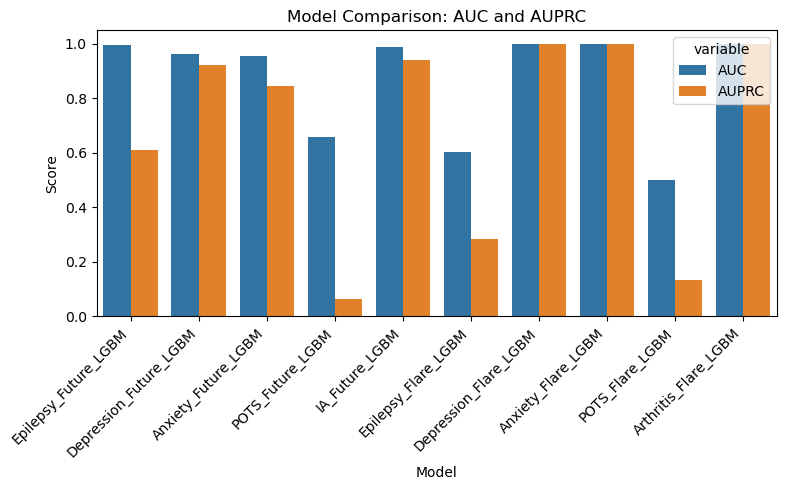

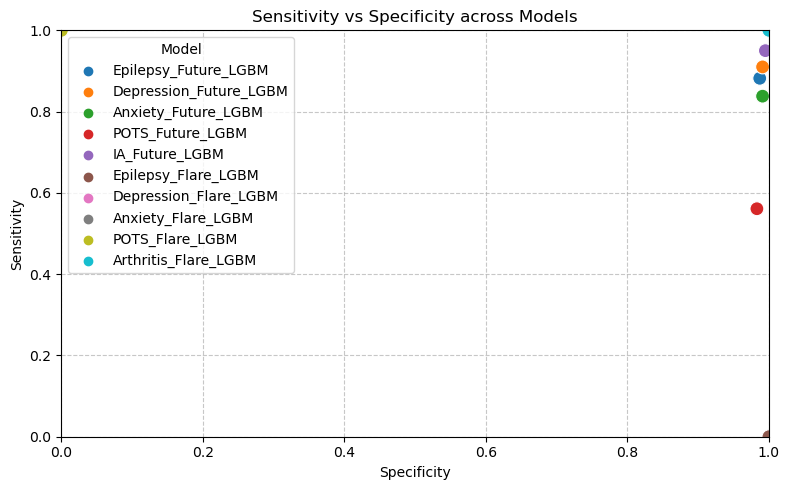

In [261]:
results_df = pd.read_csv("model_results.csv")

# --- Barplot for AUC & AUPRC --
plt.figure(figsize=(8, 5))

sns.barplot(data=results_df.melt(id_vars="Model", value_vars=["AUC", "AUPRC"]),
            x="Model", y="value", hue="variable")
plt.title("Model Comparison: AUC and AUPRC")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# --- Sensitivity vs Specificity ---
plt.figure(figsize=(8, 5))
sns.scatterplot(data=results_df, x="Specificity", y="Sensitivity", hue="Model", s=100)
plt.title("Sensitivity vs Specificity across Models")
plt.xlim(0, 1); plt.ylim(0, 1)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [262]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, (p_test >= 0.5).astype(int))
plt.title(f"{model_name} Confusion Matrix")
plt.savefig(f"plots/{model_name}_confusion.png")


NameError: name 'y_test' is not defined

### **Table 1. Cohort Summary and Label Prevalence**

| Condition / Model               | Positive Users (n) | Total Users (n) | % Positive Users | Flare Positives (n) | % Flare Days (Positive Rate) |
|---------------------------------|-------------------|----------------|-----------------|--------------------|-----------------------------|
| **Epilepsy (seizure)**          | 36                | 42,283          | 0.074 %          | 13                 | 16.05 %                      |
| **Depression**                  | 619               | 42,283          | 1.98 %           | 308                | 20.87 %                      |
| **Anxiety**                     | 340               | 42,283          | 1.45 %           | 211                | 17.78 %                      |
| **POTS (dysautonomia)**         | 26                | 42,283          | 0.07 %           | 12                  | —                            |
| **Inflammatory Arthritis**      | 157                 | 42,283               | 0.401%                | 68                 | 23.37 %                      |


**Notes:**  
*Positive users* represent individuals who ever reported the corresponding condition.  
*Flare positives* denote days meeting the next-day flare criteria among users with that condition.  
Rates are calculated within each disease-specific subset of the 42,283-user cohort.
